# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
# Se importan las librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import catboost
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
# Se carga el archivo
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
# Se hace un análisis inicial de la información
df.info()
print()
print(df.describe())
print()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000



,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
# Se convierte el formato de la columna 'datetime' de object a datetime64
df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
# Establecemos la columna de fecha como índice
df.set_index('datetime', inplace=True)

In [6]:
# Se verifica que el df este en orden cronológico
df.index.is_monotonic_increasing
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
# Remuestreo por hora 
# Agrupar por horas y sumar los pedidos
df_r = df.resample('H').sum()  
df_r.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**En este punto, ya hemos preparado el DataFrame con los datos necesarios. Se ha reducido la cantidad de entradas, ya que ahora nos enfocaremos en analizar la información para predecir los viajes que se realizarán en la próxima hora.**

## Análisis

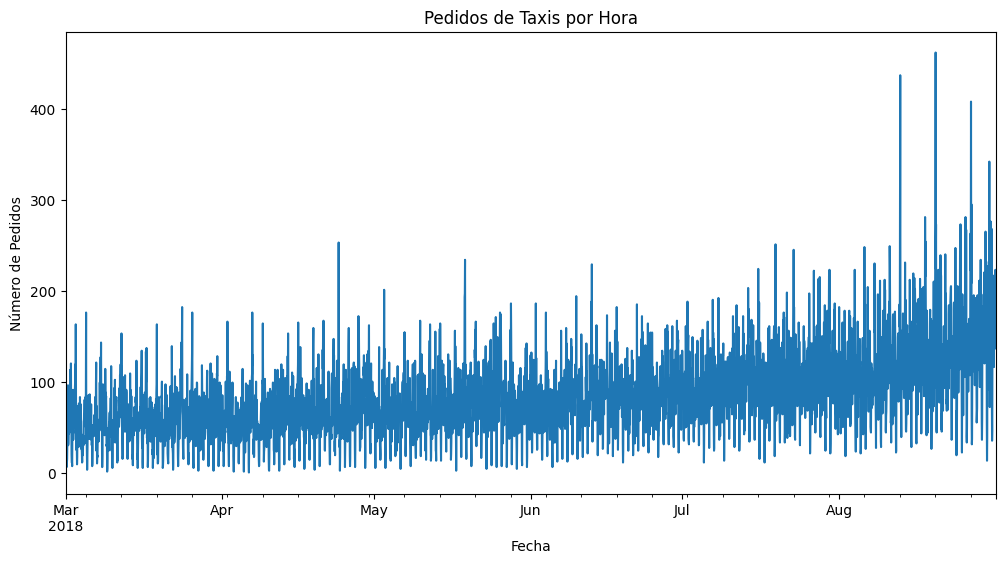

In [8]:
# Visualizamos los datos de los pedidos
df_r['num_orders'].plot(figsize=(12,6))
plt.title('Pedidos de Taxis por Hora')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.show()

In [9]:
# Se crean una funcion para crear nuevas caracteristicas, obtener la media móvil y 
def make_features(data, max_lag, rolling_mean_size):
    # Se crean características adicionales (hora, día de la semana, mes)
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    # Se calculan los valores de desfase
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # Se calcula la media móvil
    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())


make_features(df, 6, 10)

In [10]:
# Se dividen los datos en entrenamiento y prueba
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']
X_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']

In [11]:
# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**En este punto, los datos ya están preparados, lo que nos permite proceder con el entrenamiento de varios modelos.**

## Formación

### Regresión lineal

In [12]:
# Entrenamiento de modelo
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predicciones  con el conjutno de prueba
y_pred_lr = lr.predict(X_test_scaled)

# Evaluación del modelo
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = sqrt(mse_lr)
print(f'RMSE de Linear Regression: {rmse_lr}')

RMSE de Linear Regression: 8.427563179292026


### Bosque aleatorio

In [13]:
# 2. Random Forest Regressor
rf = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=12345)
rf.fit(X_train_scaled, y_train)

# Predicciones del conjunto de prueba
y_pred_rf = rf.predict(X_test_scaled)

# Evaluacion del modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = sqrt(mse_rf)
print(f'RMSE de Random Forest: {rmse_rf}')

RMSE de Random Forest: 8.501417306693519


### Árbol de desición

In [14]:
# Entrenamiento de modelo
dt = DecisionTreeRegressor(max_depth=10, random_state=12345)
dt.fit(X_train_scaled, y_train)

# Predicciones del conjunto de prueba
y_pred_dt = dt.predict(X_test_scaled)

# Evaluacion del modelo
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = sqrt(mse_dt)
print(f'RMSE de Decision Tree: {rmse_dt}')

RMSE de Decision Tree: 9.898452519257905


### CatBoost

In [15]:
# Entrenamiento de modelo
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=10, verbose=200, random_seed=12345)
catboost_model.fit(X_train, y_train)

# Predicciones del conjunto de prueba
y_pred_cat = catboost_model.predict(X_test)

# Evaluación del modelo
mse_cat = mean_squared_error(y_test, y_pred_cat)
rmse_cat = sqrt(mse_cat)
print(f'RMSE de CatBoost: {rmse_cat}')

0:	learn: 7.9487929	total: 59.6ms	remaining: 59.5s
200:	learn: 5.1970145	total: 2.19s	remaining: 8.72s
400:	learn: 4.8427935	total: 4.27s	remaining: 6.38s
600:	learn: 4.5081474	total: 6.4s	remaining: 4.25s
800:	learn: 4.1963289	total: 8.55s	remaining: 2.12s
999:	learn: 3.9298208	total: 10.7s	remaining: 0us
RMSE de CatBoost: 8.67978758290601


Entre los modelos evaluados para predecir los pedidos de taxis, Linear Regression (RMSE: 8.43) y Random Forest (RMSE: 8.50) ofrecieron los mejores resultados, con errores de predicción muy similares y bajos. CatBoost también mostró un buen rendimiento (RMSE: 8.68), pero no superó a los modelos anteriores. Decision Tree presentó el peor rendimiento (RMSE: 9.90) y requiere ajustes para mejorar su precisión.

En resumen, Linear Regression y Random Forest son los modelos más adecuados, con Linear Regression ligeramente superior.



In [18]:
# Se hace una funcion para el cálculo de RECM
def calculate_rec_error(y_true, y_pred, threshold):
    errors = np.abs(y_pred - y_true)
    sqrt_errors = np.sqrt(errors)
    error_count = np.sum(sqrt_errors > threshold)
    return (error_count / len(y_true)) * 100  # Retorna el porcentaje de errores

In [19]:
# Calcular RECM para cada modelo
rec_lr = calculate_rec_error(y_test, y_pred_lr, 48)
rec_rf = calculate_rec_error(y_test, y_pred_rf, 48)
rec_dt = calculate_rec_error(y_test, y_pred_dt, 48)
rec_cat = calculate_rec_error(y_test, y_pred_cat, 48)

In [20]:
print(f'RECM de Linear Regression: {rec_lr}')
print(f'RECM de Random Forest: {rec_rf}')
print(f'RECM de Decision Tree: {rec_dt}')
print(f'RECM de CatBoost: {rec_cat}')

RECM de Linear Regression: 0.0
RECM de Random Forest: 0.0
RECM de Decision Tree: 0.0
RECM de CatBoost: 0.0


Todos los modelos evaluados —Linear Regression, Random Forest, Decision Tree y CatBoost— han alcanzado un RECM de 0.0, lo que significa que todos lograron mantener el error (RMSE) por debajo del umbral de 48 establecido. Esto indica que, en términos de la métrica RECM, todos los modelos han cumplido con el objetivo de error definido, lo que sugiere que su rendimiento es satisfactorio para la tarea de predicción de pedidos de taxis.

En resumen, todos los modelos son aptos para su uso, ya que ninguno ha excedido el umbral de error permitido, con RECM igual a 0.0 en todos los casos.

## Prueba

In [21]:
# Predicciones  con el conjutno de prueba
y_pred_lr = lr.predict(X_test_scaled)

# Evaluación del modelo
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = sqrt(mse_lr)
print(f'RMSE de Linear Regression: {rmse_lr}')

RMSE de Linear Regression: 8.427563179292026


Luego de evaluar los diferentes modelos, Linear Regression se consideró la mejor opción debido a su precisión y simplicidad, con un RMSE más bajo y sin superar el umbral de error permitido. Este modelo es el más adecuado para la tarea de predicción de pedidos de taxis, considerando su rendimiento y facilidad de implementación.

Si en el futuro se busca mejorar aún más la precisión, podría ser útil explorar ajustes en otros modelos más complejos, pero Linear Regression es la opción más eficaz para este caso en particular.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48